In [1]:
import time
import math
import copy
import torch
import pickle
import random
import logging
import warnings
import datetime
import pandas as pd
import numpy as np
from copy import deepcopy
import torch.nn as nn
import torch.optim as opt
from torch.autograd import grad, Variable
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from imblearn.under_sampling import RandomUnderSampler
import fairlearn.datasets
from tqdm import tqdm
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import train_test_split
from torch.autograd import grad
from torch.autograd.functional import vhp
from torch.utils.data import Subset, DataLoader
from sklearn.metrics import mean_absolute_error, log_loss, r2_score, accuracy_score, precision_score, recall_score, precision_recall_fscore_support, classification_report
from scipy.stats import spearmanr
from folktables import ACSDataSource, ACSIncome, ACSPublicCoverage

import scienceplots
warnings.filterwarnings("ignore")

E = math.e

### Utility Functions

In [2]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.cm as cm
import scienceplots

In [3]:
def visualize_result(e_k_actual, e_k_estimated, ep, k_):
    plt.rcParams['figure.dpi'] = 300
    plt.style.use(['science'])
#     plt.rcParams.update({'font.size': 5})
    colors = cm.cool(np.linspace(0, 1, len(e_k_estimated)))
#     e_k_estimated = [-1*ek for ek in e_k_estimated]
    fig, ax = plt.subplots()
    
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.4f'))
    
    min_x = np.min(e_k_actual)
    max_x = np.max(e_k_actual)
    min_y = np.min(e_k_estimated)
    max_y = np.max(e_k_estimated)
    
# #     plt.rcParams['figure.figsize'] = 15, 15
    z = np.polyfit(e_k_actual,  e_k_estimated, 1)
    p = np.poly1d(z)
    xx = np.linspace(-p(2)/p(1), max(e_k_actual)+.0001)
    yy = np.polyval(p, xx)
    #add trendline to plot
    ax.plot(xx, yy, ls="-", color='k')
    
    for k in range(len(e_k_actual)):
        ax.scatter(e_k_actual[k], e_k_estimated[k], zorder=2, s=15, color=colors[k])

    ax.set_title(f'Actual vs. Estimated loss for k={k_:.2f}%', fontsize=8)
    ax.set_xlabel('Actual loss difference', fontsize=8)
    ax.set_ylabel('Estimated loss difference', fontsize=8)
   
    ax.set_xlim(min_x-.0001, max_x+.0001)
    ax.set_ylim(min_y-.0001, max_y+.0001)
    
#     #label_locations = np.arange(5)  
#     #width = 0.25 
    
#     xlabels = np.linspace(min_x-.0001, max_x+.0001, 6)
#     ylabels = np.linspace(min_y-.0001, max_y+.0001, 6)
    
    text = 'MAE = {:.03}\nP = {:.03}'.format(mean_absolute_error(e_k_actual, e_k_estimated), spearmanr(e_k_actual, e_k_estimated).correlation)
#     ax.text(max_x+.00001,min_y-.00008, text, verticalalignment='bottom', horizontalalignment='right', fontsize=8)
# #     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# #     plt.tight_layout()
    print(text)
    plt.xticks(rotation = 45, fontsize=7, visible=True)
    plt.yticks(fontsize=7)
 
    plt.show()
    # cooler color = smaller epsilon

In [4]:
def get_adult():
    train_url = 'adult.data'
    test_url = 'adult.test'

    dfTrain = pd.read_csv(train_url, header=None, sep=',')
    dfTest = pd.read_csv(test_url, header=None, sep=',', skiprows=[0])
    
    # assign column names
    columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 
                       'relationship','race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
                       'income-class']
    
    dfTrain.columns, dfTest.columns = columns, columns 
    
    dfTrain["income-class"] = dfTrain["income-class"].str.replace(".","",regex=True)
    dfTest["income-class"] = dfTest["income-class"].str.replace(".","",regex=True)
  
    # Remove question mark
    dfTrain = dfTrain[(dfTrain.values !='?').all(axis=1)]
    dfTest = dfTest[(dfTest.values !='?').all(axis=1)]

    dfTrain = dfTrain.drop(['fnlwgt','education'], axis=1)
    dfTrain = dfTrain.drop_duplicates()
    dfTrain = dfTrain.dropna(how='any', axis=0)
    
    dfTrain['workclass'] = dfTrain['workclass'].str.replace('State-gov', 'Government', regex=True)
    dfTrain['workclass'] = dfTrain['workclass'].str.replace('Federal-gov', 'Government', regex=True)
    dfTrain['workclass'] = dfTrain['workclass'].str.replace('Local-gov', 'Government', regex=True)
    dfTrain['workclass'] = dfTrain['workclass'].str.replace('Self-emp-not-inc', 'Self-Employed', regex=True)
    dfTrain['workclass'] = dfTrain['workclass'].str.replace('Self-emp-inc', 'Self-Employed', regex=True)
    dfTrain['workclass'] = dfTrain['workclass'].str.replace('Private', 'Privately-Employed', regex=True)
    
    dfTrain['occupation'] = dfTrain['occupation'].str.replace('Armed-Forces', 'Protective-serv', regex=True)
    
    dfTrain['marital-status'] = dfTrain['marital-status'].str.replace('Married-AF-spouse', 'Married', regex=True)
    dfTrain['marital-status'] = dfTrain['marital-status'].str.replace('Married-civ-spouse', 'Married', regex=True)
    dfTrain['marital-status'] = dfTrain['marital-status'].str.replace('Married-spouse-absent', 'Married', regex=True)
    dfTrain['marital-status'] = dfTrain['marital-status'].str.replace('Divorced', 'Not-married', regex=True)
    dfTrain['marital-status'] = dfTrain['marital-status'].str.replace('Never-married', 'Not-married', regex=True)
    dfTrain['marital-status'] = dfTrain['marital-status'].str.replace('Separated', 'Not-married', regex=True)
    dfTrain['marital-status'] = dfTrain['marital-status'].str.replace('Widowed', 'Not-married', regex=True)
    
    dfTrain['sex'] = dfTrain['sex'].astype('category').cat.codes
    dfTrain['income-class'] = dfTrain['income-class'].astype('category').cat.codes
    dfTrain['race'] = np.where(dfTrain['race'] == ' White', 1,0)
    
    to_replace = ['workclass', 'education-num', 'marital-status', 'occupation','relationship', 'native-country']
    dfTrain = pd.get_dummies(dfTrain, columns=to_replace, drop_first = False)
    
    dfTrain = dfTrain.drop('native-country_ Holand-Netherlands', axis=1)
    dfTrain = dfTrain.drop(['workclass_ ?', 'native-country_ ?', 'occupation_ ?'], axis=1)
    
    def numericalBinary(dataset, features):
        dataset[features] = np.where(dataset[features] >= dataset[features].mean(), 1,0)

    numericalBinary(dfTrain,['age', 'hours-per-week', 'capital-gain', 'capital-loss'])
 
    
    dfTest = dfTest.drop(['fnlwgt','education'], axis=1)
    dfTest = dfTest.drop_duplicates()
    dfTest = dfTest.dropna(how='any', axis=0)
        
    dfTest['workclass'] = dfTest['workclass'].str.replace('State-gov', 'Government', regex=True)
    dfTest['workclass'] = dfTest['workclass'].str.replace('Federal-gov', 'Government', regex=True)
    dfTest['workclass'] = dfTest['workclass'].str.replace('Local-gov', 'Government', regex=True)
    dfTest['workclass'] = dfTest['workclass'].str.replace('Self-emp-not-inc', 'Self-Employed', regex=True)
    dfTest['workclass'] = dfTest['workclass'].str.replace('Self-emp-inc', 'Self-Employed', regex=True)
    dfTest['workclass'] = dfTest['workclass'].str.replace('Private', 'Privately-Employed', regex=True)
    
    dfTest['occupation'] = dfTest['occupation'].str.replace('Armed-Forces', 'Protective-serv', regex=True)
    
    dfTest['marital-status'] = dfTest['marital-status'].str.replace('Married-AF-spouse', 'Married', regex=True)
    dfTest['marital-status'] = dfTest['marital-status'].str.replace('Married-civ-spouse', 'Married', regex=True)
    dfTest['marital-status'] = dfTest['marital-status'].str.replace('Married-spouse-absent', 'Married', regex=True)
    dfTest['marital-status'] = dfTest['marital-status'].str.replace('Divorced', 'Not-married', regex=True)
    dfTest['marital-status'] = dfTest['marital-status'].str.replace('Never-married', 'Not-married', regex=True)
    dfTest['marital-status'] = dfTest['marital-status'].str.replace('Separated', 'Not-married', regex=True)
    dfTest['marital-status'] = dfTest['marital-status'].str.replace('Widowed', 'Not-married', regex=True)
    
    dfTest['sex'] = dfTest['sex'].astype('category').cat.codes
    dfTest['income-class'] = dfTest['income-class'].astype('category').cat.codes
    dfTest['race'] = np.where(dfTest['race'] == ' White', 1,0)
    
    dfTest = pd.get_dummies(dfTest, columns=to_replace, drop_first = False)

    numericalBinary(dfTest,['age', 'hours-per-week', 'capital-gain', 'capital-loss'])
    
    dfTest = dfTest.drop(['workclass_ ?', 'native-country_ ?', 'occupation_ ?'], axis=1)
    
    data = pd.concat([dfTrain, dfTest], axis=0, ignore_index=False)
    data = data.sample(frac=1, ignore_index=True)
    

    num_train = int(len(data) * .8)
    dfTrain = data.sample(n=num_train, replace=False, axis=0, ignore_index=False)

    dfTest = data.drop(dfTrain.index, axis=0)
    
    dfTrain = dfTrain.dropna(how='any', axis=0)
    dfTest = dfTest.dropna(how='any', axis=0)

    label = 'income-class'
    return dfTrain, dfTest, label

In [5]:
 class CreateData(torch.utils.data.Dataset):
    def __init__(self, data, targets, pert_status):
        self.data = data
        self.targets = targets
        self.pert = pert_status

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        out_data = self.data[idx]
        out_label = self.targets[idx]
        pert_label = self.pert[idx]

        return out_data, out_label, pert_label

In [6]:
def get_data(dfTrain, feature_set, label, k):    

    selected_group = dfTrain.loc[dfTrain['sex'] == 0]

    num_to_sample = int((k/100)*len(dfTrain))

    sampled_group = selected_group.sample(n=num_to_sample, ignore_index=False)
    not_selected = dfTrain.drop(sampled_group.index)

    selected_group_X = sampled_group[feature_set]
    selected_group_y = sampled_group[label]

    not_selected_group_X = not_selected[feature_set]
    not_selected_group_y = not_selected[label]   
    
    return selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y


### Randomized Response

In [7]:
def get_p(epsilon):
    prob_stay = (E ** epsilon) / (1 + (E ** epsilon))
    prob_change = 1 / (1 + (E ** epsilon))
    
    p = torch.zeros(2,2)
    for i in range(2):
        for j in range(2):
            if i == j: 
                p[i][j] = prob_stay
            else:
                p[i][j] = prob_change
    
    return p

In [8]:
def forward_correct_loss(y_act, oupt, epsilon, criterion, device):
    
    p = get_p(epsilon)
    y_pred_c = torch.matmul(oupt, p.to(device)) 
    loss = criterion(torch.log(y_pred_c), y_act.ravel())
    
    return loss 

### Models

In [9]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        
        self.fc1 = torch.nn.Linear(num_features, 2)
        self.criterion = torch.nn.NLLLoss(reduction='mean')
        self.activ = torch.nn.Softmax()
        
    def forward(self, x):
        probs = self.activ(self.fc1(x))

        return probs
    
    def loss(self, test_loader, print_, device):
        correct = 0
        total = 0
        all_labels = []
        all_predicted = []
        all_loss = 0
        
        for features, labels, _ in test_loader:
            features = Variable(features).to(device)
            labels = Variable(labels).to(device)
            outputs = self.fc1(features)
            loss = self.criterion(outputs, labels)
            all_loss += loss
            _, predicted = torch.max(outputs.data, 1)
            total+= labels.size(0)
            
            all_labels.extend(list(labels.detach().cpu().numpy()))
            all_predicted.extend(list(predicted.detach().cpu().numpy()))
            correct+= (predicted.detach().cpu().numpy() == labels.detach().cpu().numpy()).sum()
        acc = 100 * correct/total
        
        return loss/len(test_loader), acc

In [10]:
def train(model, dataset, epsilon, lengths, device):
    model.train()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=.005, weight_decay=0)
    criterion = torch.nn.NLLLoss(reduction='mean')
    pert_status = np.zeros(len(dataset[0]))
 
    if lengths is not None:
        len_original = lengths[0]
        len_perts = lengths[1]
        total_len = len(dataset[0])
        pert_status = []
        pert_status.extend(np.zeros(len_original))
        pert_status.extend(np.ones(len_perts))
    
    train_data = CreateData(dataset[0], dataset[1], pert_status)
    train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)
        
    for itr in range(0, 7):
        itr_loss = 0
        correct = 0
        total = 0
        
        for i, (features, labels, pert_val) in enumerate(train_dataloader):
            features = Variable(features).to(device)
            labels = Variable(labels).to(device)
           
            optimizer.zero_grad()
            outputs = model(features)
            
            if pert_val == 0:
                loss_val = criterion(torch.log(outputs), labels.ravel())
            else:
                loss_val = forward_correct_loss(labels, outputs, epsilon, torch.nn.NLLLoss(reduction='sum'), device)

            itr_loss += loss_val
            loss_val.backward()
            optimizer.step()
            
            _, predicted = torch.max(outputs.data, 1)
            total+= labels.size(0)
            correct+= (predicted.detach().cpu() == labels.detach().cpu()).sum()
                        
    return model

### Influence Calculation Functions


In [11]:
def calc_influence_single(model, epsilon, train_dataset, train_dataloader, test_dataloader, group_data, device, criterion, hessian):
    start = time.time()
    
    if hessian is None:
        s_test_vec = s_test_sample(model, test_dataloader, train_dataset, device, criterion)
    else:
        s_test_vec = hessian
   
    grad_z_vec = grad_training([group_data[0], group_data[1]], model, device, epsilon)
    
    with torch.no_grad():
        influence = (sum([torch.sum(k * j).data for k, j in zip(grad_z_vec, s_test_vec)]) / len(train_dataset))
            
    end = time.time() - start

    return influence.cpu(), end, s_test_vec

In [12]:
def s_test_sample(model, test_dataloader, train_dataset, device, criterion):
    scale = 25
    damp = 0.01
    recursion_depth = 7500
    r = 3
    
    inverse_hvp = [torch.zeros_like(params, dtype=torch.float) for params in model.parameters()]
    
    for i in range(r):
        hessian_loader = DataLoader(train_dataset, sampler=torch.utils.data.RandomSampler(train_dataset, True, num_samples=recursion_depth), batch_size = 1)
        
        cur_estimate = s_test(test_dataloader, model, i, hessian_loader, device, damp, scale, criterion)
        
        with torch.no_grad():
            inverse_hvp = [old + (cur/scale) for old,cur in zip(inverse_hvp, cur_estimate)]
    
    with torch.no_grad():
        inverse_hvp = [component / r for component in inverse_hvp]
        
    return inverse_hvp

In [13]:
def s_test(test_dataloader, model, i, hessian_loader, device, damp, scale, criterion):
    v = grad_z(test_dataloader, model, device, criterion)
    h_estimate = v
    
    params, names = make_functional(model)
    params = tuple(p.detach().requires_grad_() for p in params)
    
    progress_bar = tqdm(hessian_loader, desc=f"IHVP sample {i}")
    
    for i, (x_train, y_train, _) in enumerate(progress_bar):
        x_train = Variable(x_train).to(device)
        y_train = Variable(y_train).to(device)
        
        def f(*new_params):
            load_weights(model, names, new_params)
            out = model(x_train)
            loss = criterion(out, y_train)
            return loss
    
        hv = vhp(f, params, tuple(h_estimate), strict=True)[1]
        
        with torch.no_grad():
            h_estimate = [
                _v + (1-damp) * _h_e - _hv / scale for _v, _h_e, _hv in zip(v, h_estimate, hv)
            ]
            
            if i % 100 == 0:
                norm = sum([h_.norm() for h_ in h_estimate])
                progress_bar.set_postfix({"est norm": norm.item()})
                
    with torch.no_grad():
        load_weights(model, names, params, as_params=True)
        
    return h_estimate

In [14]:
def make_functional(model):
    orig_params = tuple(model.parameters())
    names = []
    
    for name, p in list(model.named_parameters()):
        del_attr(model, name.split("."))
        names.append(name)
    
    return orig_params, names

In [15]:
def del_attr(obj, names):
    if len(names) == 1:
        delattr(obj, names[0])
    else:
        del_attr(getattr(obj, names[0]), names[1:])

In [16]:
def set_attr(obj, names, val):
    if len(names) == 1:
        setattr(obj, names[0], val)
    else:
        set_attr(getattr(obj, names[0]), names[1:], val)

In [17]:
def load_weights(model, names, params, as_params=False):
    for name, p in zip(names, params):
        if not as_params:
            set_attr(model, name.split("."), p)
        else:
            set_attr(model, name.split("."), torch.nn.Parameter(p))

In [18]:
def grad_z(test_data, model, device, criterion):

    model.eval()

    itr_loss = 0
    for i, (images, labels, _) in enumerate(test_data):
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        itr_loss += loss

    loss_ = itr_loss / len(test_data)
    return grad(loss_, model.parameters())

In [19]:
def grad_training(train_data, model, device, epsilon):

    model.eval()

    x_train_input = torch.FloatTensor(train_data[0].values).to(device)
    y_train_input = torch.LongTensor(train_data[1].values).to(device)
    pert_status = np.ones(len(train_data[0]))
    
    train_data = CreateData(x_train_input, y_train_input, pert_status)
    train_dataloader = DataLoader(train_data, batch_size=1, shuffle=True)

    criterion = torch.nn.CrossEntropyLoss(reduction='sum')
    
    agg_loss=0
    possible_labels = [0,1]
    for i, (feature, label, _) in enumerate(train_dataloader):
        pert_agg_loss = 0
        
        output = model(feature)
        orig_loss = criterion(output, label)

        for j in possible_labels:
            if j != label.item():
                pert_label = torch.LongTensor([j]).to(device)
                pert_loss = forward_correct_loss(pert_label, output, epsilon, criterion, device)
                pert_agg_loss += (pert_loss - orig_loss)
                
        agg_loss += pert_agg_loss
        
    loss = float(1/(1 + (E ** epsilon)))*(agg_loss)
    
    to_return = grad(loss, model.parameters())
        
    return to_return

### Main Function

In [20]:
def Main(dataset, epsilons, ks, num_rounds):

    device = 'cuda:6' if torch.cuda.is_available() else 'cpu'
    criterion = torch.nn.NLLLoss(reduction='mean')
    
    all_orig_loss_e_k = []
    all_est_loss_e_k = []
    all_time = []
    
    for nr in range(num_rounds):
        print(f'\nRound {nr+1}')
        ############
        # Get data #
        ############
        print('\nGetting Data...')

        dfTrain, dfTest, label = get_adult()

        feature_set = list(set(dfTrain.columns) - {label})
        num_features = len(feature_set)

        X_train, X_test = dfTrain[feature_set], dfTest[feature_set]
        y_train, y_test = dfTrain[label], dfTest[label]
        
        
        x_test_input = torch.FloatTensor(X_test.values).to(device)
        y_test_input = torch.LongTensor(y_test.values).to(device)
        pert_status_test = np.ones(len(x_test_input))
        
        x_train_input = torch.FloatTensor(X_train.values).to(device)
        y_train_input = torch.LongTensor(y_train.values).to(device)
        pert_status_train = np.ones(len(x_train_input))
    
        train_dataset = CreateData(x_train_input, y_train_input, pert_status_train)
        test_dataset = CreateData(x_test_input, y_test_input, pert_status_test)

    
        train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
        test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)
   
        ##############################################
        # Train original model and get original loss #
        ##############################################
        print('Training original model...')
        torch_model = LogisticRegression(num_features)
        torch.save(torch_model.state_dict(), 'initial_config.pth')
        torch_model.to(device)
        torch_model = train(torch_model, [x_train_input, y_train_input], None, None, device)
        test_loss_ori, acc_ori = torch_model.loss(test_loader, True, device)

        e_k_act_losses = []
        e_k_est_losses = []
        influence_time = []
        
        ################################################################
        # Perform influence and retraining for all epsilons a k values #
        ################################################################
        print('\nBegining epsilon and k rounds')
        print('-----------------------------')
        for k_elem, k in enumerate(ks):
            print(f'\nk: {k}')
            hessian = None
            k_act_losses = []
            k_est_losses = []
            inf_time = []
            
            for ep_elem, ep in enumerate(epsilons):
                # Influence
                print(f'ep: {ep}')
                selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y = get_data(dfTrain, feature_set, label, k)
                loss_diff_approx, tot_time, hessian = calc_influence_single(torch_model, ep, train_dataset, train_loader, test_loader, [selected_group_X, selected_group_y, not_selected_group_X, not_selected_group_y], device, criterion, hessian)
                loss_diff_approx = -torch.FloatTensor(loss_diff_approx).cpu().numpy()
                print(f'Approx difference: {loss_diff_approx:.5f}')
                
                # Retrain - need to actually perturb
                p = ((E**ep)/(1+(E**ep)))
                p_change = (1/(1+(E**ep)))

                pert_selected_group_y = []
                
                for i, elem in enumerate(selected_group_y.values):
                    rnd = np.random.random()
                    if rnd <= p:
                        pert_selected_group_y.append(elem)
                    else:
                        pert_selected_group_y.append(1 - elem)
                    
                y_w_group_pert = pd.concat([not_selected_group_y, pd.DataFrame(pert_selected_group_y)], axis = 0, ignore_index=True ) 
                y_wo_pert = pd.concat([not_selected_group_y, selected_group_y], axis = 0, ignore_index=True)
                reconstructed_x = pd.concat([not_selected_group_X, selected_group_X], axis = 0, ignore_index=True)
                                           
                x_train_input_pert = torch.FloatTensor(reconstructed_x.values).to(device)
                y_train_input_pert = torch.LongTensor(y_w_group_pert.values).to(device)

                model_pert = LogisticRegression(num_features)
                model_pert.load_state_dict(torch.load('initial_config.pth'))
                model_pert.to(device)
                model_pert = train(model_pert, [x_train_input_pert, y_train_input_pert], ep, [len(not_selected_group_y), len(selected_group_y)], device)
                test_loss_retrain, acc_retrain = model_pert.loss(test_loader, True, device)

                 # get true loss diff
                loss_diff_true = (test_loss_retrain - test_loss_ori).detach().cpu().item()
                print(f'True difference: {loss_diff_true:.5f}')
                k_act_losses.append(loss_diff_true)
                k_est_losses.append(loss_diff_approx)
                inf_time.append(tot_time)
            
            visualize_result(k_act_losses, k_est_losses, epsilons, k)
            e_k_act_losses.append(k_act_losses)
            e_k_est_losses.append(k_est_losses)
            influence_time.append(inf_time)
            
        all_orig_loss_e_k.append(e_k_act_losses)
        all_est_loss_e_k.append(e_k_est_losses) 
        all_time.append(influence_time)
    
    return all_orig_loss_e_k, all_est_loss_e_k, all_time

### Perform Experiment 

#### Constants

In [21]:
epsilons = np.linspace(.001, 5, 30) #30 5
k = [17.11,30] #10
rounds = 1


Round 1

Getting Data...
Training original model...

Begining epsilon and k rounds
-----------------------------

k: 17.11
ep: 0.001


IHVP sample 2: 100%|████████████████████████████████████████████████| 7500/7500 [00:07<00:00, 994.86it/s, est norm=5.68]


Approx difference: 0.00051
True difference: 0.00004
ep: 0.17337931034482756
Approx difference: 0.00060
True difference: -0.00020
ep: 0.3457586206896551
Approx difference: 0.00075
True difference: -0.00039
ep: 0.5181379310344827
Approx difference: 0.00086
True difference: -0.00052
ep: 0.6905172413793103
Approx difference: 0.00093
True difference: -0.00035
ep: 0.8628965517241378
Approx difference: 0.00103
True difference: -0.00019
ep: 1.0352758620689653
Approx difference: 0.00112
True difference: -0.00028
ep: 1.207655172413793
Approx difference: 0.00120
True difference: -0.00006
ep: 1.3800344827586204
Approx difference: 0.00124
True difference: 0.00012
ep: 1.5524137931034478
Approx difference: 0.00131
True difference: 0.00039
ep: 1.7247931034482755
Approx difference: 0.00123
True difference: -0.00000
ep: 1.8971724137931032
Approx difference: 0.00123
True difference: -0.00016
ep: 2.0695517241379306
Approx difference: 0.00121
True difference: -0.00007
ep: 2.241931034482758
Approx differenc

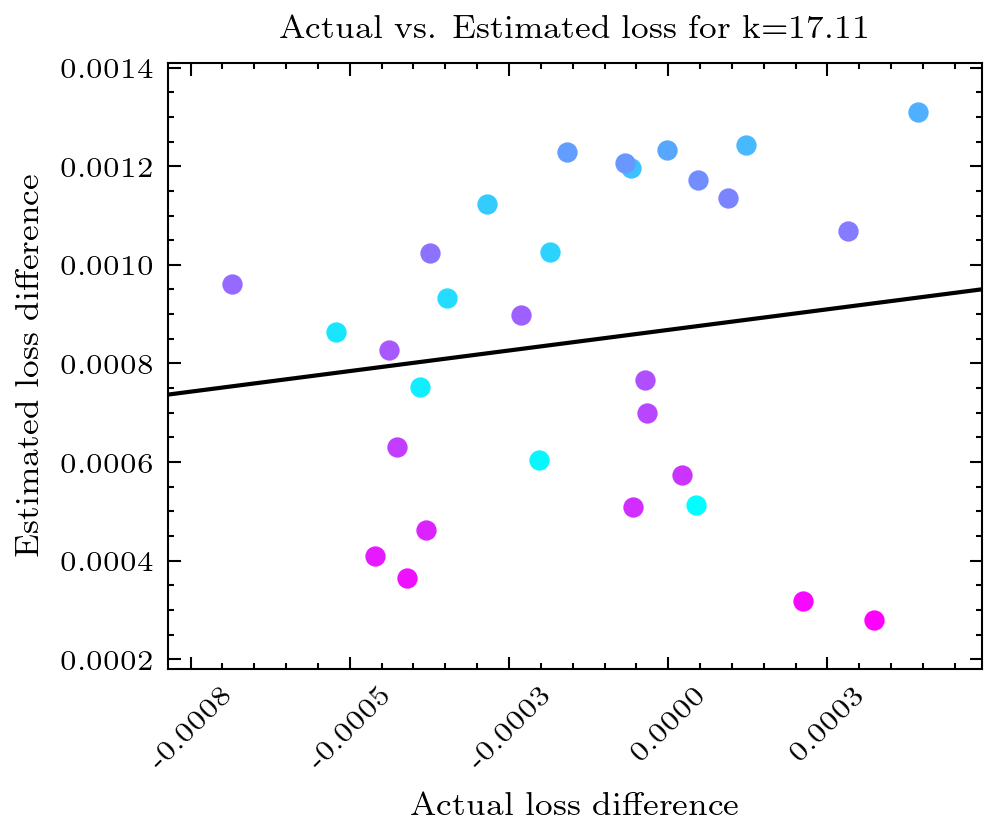


k: 30
ep: 0.001


IHVP sample 2: 100%|███████████████████████████████████████████████| 7500/7500 [00:07<00:00, 1003.04it/s, est norm=4.76]


Approx difference: 0.00081
True difference: 0.00055
ep: 0.17337931034482756
Approx difference: 0.00100
True difference: 0.00006
ep: 0.3457586206896551
Approx difference: 0.00121
True difference: 0.00063
ep: 0.5181379310344827
Approx difference: 0.00140
True difference: 0.00020
ep: 0.6905172413793103
Approx difference: 0.00154
True difference: 0.00006
ep: 0.8628965517241378
Approx difference: 0.00171
True difference: 0.00023
ep: 1.0352758620689653
Approx difference: 0.00182
True difference: 0.00005
ep: 1.207655172413793
Approx difference: 0.00193
True difference: 0.00015
ep: 1.3800344827586204
Approx difference: 0.00197
True difference: 0.00010
ep: 1.5524137931034478
Approx difference: 0.00198
True difference: 0.00025
ep: 1.7247931034482755
Approx difference: 0.00202
True difference: -0.00003
ep: 1.8971724137931032
Approx difference: 0.00198
True difference: 0.00029
ep: 2.0695517241379306
Approx difference: 0.00193
True difference: 0.00009
ep: 2.241931034482758
Approx difference: 0.0018

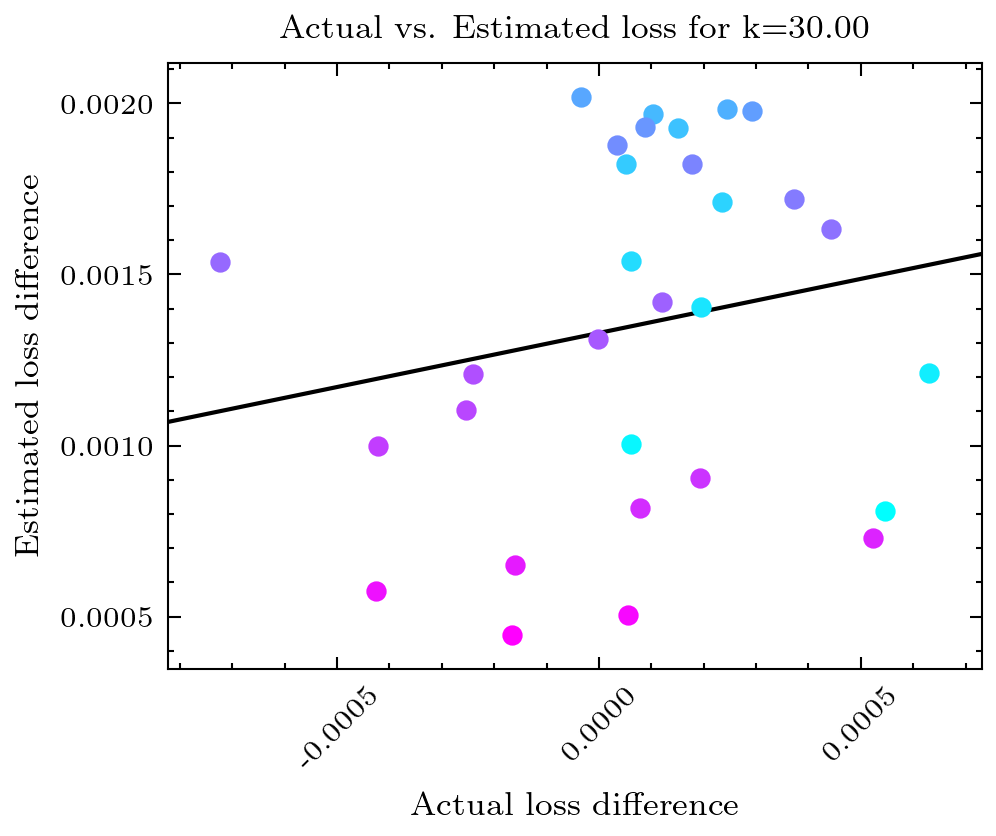

In [22]:
all_orig_loss_e_k, all_est_loss_e_k, all_time = Main('mnist', epsilons, k, rounds)

with open('all_orig_loss_e_k_mnist_flc.txt', "wb") as file:   #Pickling
    pickle.dump(all_orig_loss_e_k, file)

with open('all_est_loss_e_k_mnist_flc.txt', "wb") as file2:   #Pickling
    pickle.dump(all_est_loss_e_k, file2)

In [23]:
with open('all_orig_loss_e_k_mnist_flc.txt', 'rb') as f:
    all_orig_loss_e_k = pickle.load(f)
    
with open('all_est_loss_e_k_mnist_flc.txt', 'rb') as f:
    all_est_loss_e_k = pickle.load(f)

In [24]:
# [actual, estimate]

sum_orig_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_est_loss_e_k = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]
sum_time = [[0 for _ in range(len(k))] for _ in range(len(epsilons))]

avg_orig_loss = []
avg_est_loss = []
avg_time = []

for round_ in range(len(all_orig_loss_e_k)):
    for e in range(len(epsilons)):
        for k_ in range(len(k)):
            sum_orig_loss_e_k[e][k_] = sum_orig_loss_e_k[e][k_] + all_orig_loss_e_k[round_][e][k_]
            sum_est_loss_e_k[e][k_] = sum_est_loss_e_k[e][k_] + all_est_loss_e_k[round_][e][k_]
            sum_time[e][k_] = sum_time[e][k_] + all_time[round_][e][k_]

for e in range(len(epsilons)):
    avg_orig_loss.append([ elem / len(all_orig_loss_e_k) for elem in sum_orig_loss_e_k[e]])
    avg_est_loss.append([elem/ len(all_orig_loss_e_k) for elem in sum_est_loss_e_k[e]])
    avg_time.append([elem/ len(all_orig_loss_e_k) for elem in sum_time[e]])

k_e_orig = [[] for _ in range(len(k))]
k_e_est = [[] for _ in range(len(k))]

for e in range(len(epsilons)):
    for k_ in range(len(k)):
        k_e_orig[k_].append(avg_orig_loss[e][k_])
        k_e_est[k_].append(avg_est_loss[e][k_])

averaged_time = []

for e in range(len(epsilons)):
    averaged_time.append(sum_time[e][0])

average_time_final = sum(averaged_time) / len(averaged_time)

IndexError: list index out of range

In [ ]:
for i in range(len(k_e_orig)):
    visualize_result(k_e_orig[i], k_e_est[i], epsilons, k[i])